# 1 Preliminaries
## 1.1 Import
Import required libraries.

In [31]:
import os
import pandas as pd
import numpy as np
from keras import callbacks, layers, models, optimizers, utils
import json
import chess
import chess.pgn

## 1.2 Load Data
Load the pgn file and create DataFrame. It should have three columns:
- Color
- Board
- Move

In [26]:
def space_to_int(space):
    row_val = {'a': 0,'b': 1,'c': 2,'d': 3,'e': 4,'f': 5,'g': 6,'h': 7}
    letter = chess.square_name(space) # returns letter of space (ex. a3)
    return 8-int(letter[1]), row_val[letter[0]] # returns row, column

def split_boards(board):
    """
    Splits board into 14 different boards
    :param board: current board
    :return: length 14 array of boards based on piece location and attack
    0-5 are white pieces (pawn, knight, bishop, rook, queen, king)
    6-11 is black pieces (pawn, knight, bishop, rook, queen, king)
    12 is white legal moves
    13 is black legal moves
    """
    res = np.zeros((14, 8, 8), dtype=np.int8) # creates array of length 14 where each element is a board
    
    for piece in chess.PIECE_TYPES:
        for square in board.pieces(piece, chess.WHITE):
            # gets the location of where the square is and stores it into res
            index = np.unravel_index(square, (8,8)) # see https://stackoverflow.com/questions/48135736/what-is-an-intuitive-explanation-of-np-unravel-index
            res[piece-1][7-index[0]][index[1]] = 1 # 7-index[0] is row, index[1] is column
        for square in board.pieces(piece, chess.BLACK):
            # same idea but black pieces this time
            index = np.unravel_index(square, (8,8))
            res[piece+5][7-index[0]][index[1]] = 1 # +5 because of res indexing
        
    turn = board.turn # store current turn to use later
    
    # get legal moves for white
    board.turn = chess.WHITE
    for move in board.legal_moves:
        r, c = space_to_int(move.to_square)
        res[12][r][c] = 1
        
    # get legal moves for black
    board.turn = chess.BLACK
    for move in board.legal_moves:
        r, c = space_to_int(move.to_square)
        res[13][r][c] = 1
        
    board.turn = turn # restore original turn
    
    return res

def read_data(file):
    X_res = []
    y_res = []
    while True:
        try:
            game = chess.pgn.read_game(file)
            
            if game is None:
                break
                
            board = game.board()
            
            color = "white" if game.headers["White"] == file.name[:-4] else "black"
            
            for move in game.mainline_moves():
                if(color == "white" and board.turn == chess.WHITE) or (color == "black" and board.turn == chess.BLACK):
                    X_res.append(split_boards(board))
                    y_res.append(move.uci())
                board.push(move)
        except Exception as e:
            print(e)
    return X_res, y_res

def encode_moves(moves):
    move_to_int = {move: idx for idx, move in enumerate(set(moves))}
    return [move_to_int[move] for move in moves], move_to_int

X_train = []
y_train = []
directory = '../data'
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)

    if os.path.isfile(f) and filename[-3:] == "pgn":
        with open(f, 'r') as pgn:
            print(f)
            X_res, y_res = read_data(pgn)
            X_train += X_res
            y_train += y_res

y_train, move_to_int = encode_moves(y_train)
y_train = utils.to_categorical(y_train, num_classes=len(move_to_int))

X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape)
print(y_train.shape)

../data/damnsaltythatsport.pgn
../data/DannytheDonkey.pgn
../data/DrGrekenstein.pgn
../data/DrDrunkenstein.pgn
../data/manwithavan.pgn
../data/DrNykterstein.pgn


illegal san: 'Ng1' in rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1 while parsing <Game at 0x14c83fb60 ('?' vs. '?', '????.??.??' at '?')>


'utf-8' codec can't decode byte 0xe4 in position 1147: invalid continuation byte


illegal san: 'Rac8' in rnbqkbnr/pppppppp/8/8/8/P7/1PPPPPPP/RNBQKBNR b KQkq - 0 1 while parsing <Game at 0x153d2f5f0 ('?' vs. '?', '????.??.??' at '?')>


'utf-8' codec can't decode byte 0xc5 in position 7052: invalid continuation byte
'utf-8' codec can't decode byte 0xc5 in position 1045: invalid continuation byte
'utf-8' codec can't decode byte 0xc5 in position 486: invalid continuation byte
../data/DrChampionstein.pgn
../data/STL_Carlsen.pgn
../data/MagnusCarlsen.pgn
../data/neslraCsungaM77.pgn
(561824, 14, 8, 8)
(561824, 1825)


# 2 Train Model
## 2.1 Create Model

In [27]:
def create_model():
    
    model = models.Sequential([
        layers.Input(shape=(14,8,8)),
        layers.Conv2D(64, kernel_size=3, activation='relu'),
        layers.Conv2D(128, kernel_size=3, activation='relu'),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(len(move_to_int), activation='softmax')
    ])
    
    optimizer = optimizers.Adam()
    loss = 'categorical_crossentropy'
    metrics = ['accuracy']
    
    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=metrics
    )
    
    # print(model.summary())
    
    return model

## 2.2 Fit Model

8779/8779 ━━━━━━━━━━━━━━━━━━━━ 182s 21ms/step - accuracy: 0.6030 - loss: 1.3734
Epoch 100/100
8779/8779 ━━━━━━━━━━━━━━━━━━━━ 164s 19ms/step - accuracy: 0.6017 - loss: 1.3758


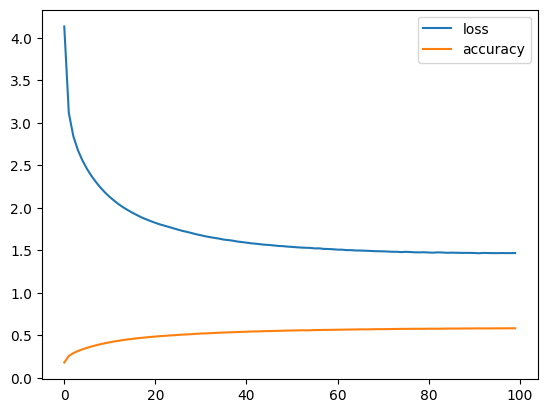

In [29]:
model = create_model()

# model = models.load_model('../models/ai.keras')

early_stopping = callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0.001,  # minimium amount of change to count as an improvement
    patience=20,  # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=100,
    callbacks=[
        early_stopping,
    ],
    verbose=1,
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'accuracy']].plot()

model.save('../models/ai.keras')

## 2.3 Evaluate Model

In [ ]:
model = models.load_model('../models/ai.keras')

# X_test, y_test = load_data(1)
# 
# score = model.evaluate(X_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test mean absolute error:', score[1])

# 3 Prepare Model
## 3.1 Export Dictionary

In [32]:
int_to_move = dict(zip(move_to_int.values(), move_to_int.keys()))

with open('dict.json', 'w') as f:
    json.dump(int_to_move, f)